In [2]:
import numpy as np
import pyart
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

In [14]:
import pyart

# Example list of radar files
filenames = [
    "./Data/KHGX20210628_131818_V06", 
    "./Data/KHGX20210628_000535_V06" # Example file path
    # Add more file paths here
]

# List to store grids
grids = []
radars = []

# Loop over each file
for filename in filenames:
    # Read the radar file
    radar = pyart.io.read(filename)

    # Set weighting function
    weight_func = 'Barnes'  # Options: 'nearest', 'Cressman', 'Barnes'

    # Create a gate filter
    gfilter = pyart.filters.GateFilter(radar)
    gfilter.exclude_below('cross_correlation_ratio', 0.8)
    gfilter.exclude_below('reflectivity', -20)

    # Create a grid based on our radar object
    grid = pyart.map.grid_from_radars(
        radar,
        grid_shape=(41, 401, 401),
        gridding_algo='map_gates_to_grid',
        weighting_function=weight_func,
        gatefilters=gfilter,
        grid_limits=(
            (0.0, 20000),
            (-100000.0, 100000.0),
            (-100000, 100000.0),
        ),
    )

    # Store the grid for further processing
    grids.append(grid)
    radars.append(radar)

    # Additional processing can be done here
    # For example, working with the grid data


In [4]:
#CFAD settings
zlims=[-20, 65]
zdrlims=[-1, 3]
rholims=[0.9, 1.02]
kdplims=[-1,3]
#lims = [-50000,0,-75000,30000]
lims=[-100000,-50000,-50000,50000]
#lims = [-50000,50000,-50000,50000]
ymax=10
norm_opt = 2 #1) Normalize at each height only, 2) Normalize across all heights

#CFAD increment
dz = 5
dzdr = 0.5
drho = 0.0025
dkdp = 0.1

#KDP calc
kdp_calc = False

In [5]:
#Calculate KDP if desired
if(kdp_calc):
    kdp_vulpiani = pyart.retrieve.kdp_vulpiani(radar, gatefilter=None, band='S', windsize=10, n_iter=10, interp=False,parallel=True)
    radar.add_field('kdp', kdp_vulpiani[0])

In [86]:
Z = np.ma.concatenate([grids[0].fields['reflectivity']['data'], grids[1].fields['reflectivity']['data']], axis=2)
rho = np.ma.concatenate([grids[0].fields['cross_correlation_ratio']['data'], grids[1].fields['cross_correlation_ratio']['data']], axis=2)
ZDR = np.ma.concatenate([grids[0].fields['differential_reflectivity']['data'], grids[1].fields['differential_reflectivity']['data']], axis=2)

In [85]:
grids[0].fields['reflectivity']['data'].shape

(41, 401, 401)

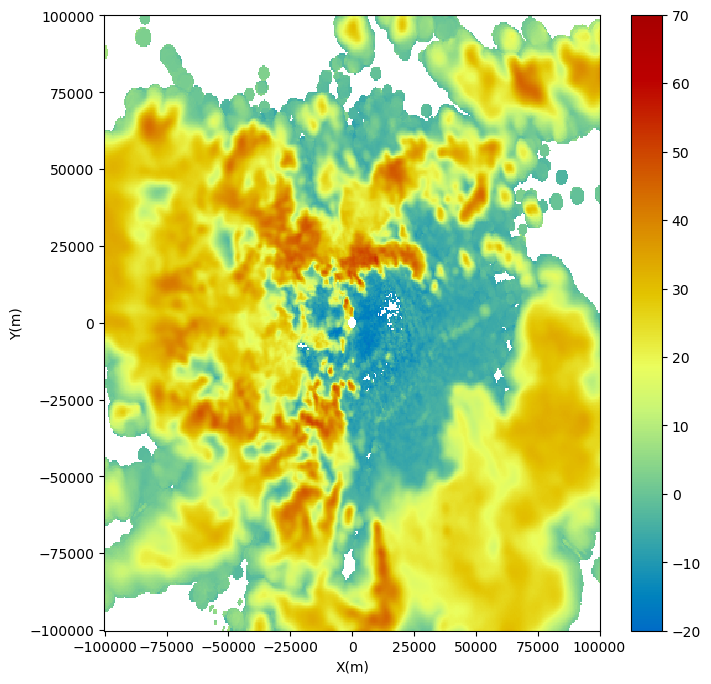

In [17]:
# In Py-ART's graphing suite, there is a display class similar to RadarMapDisplay,
# but for grids. To plot the grid:

[X,Y]=np.meshgrid(grids[1].x["data"],grids[1].y["data"])
lev=2 #Level of analysis
fig = plt.figure(figsize=(8,8))
plt.pcolormesh(X,Y,np.squeeze(Z[lev,:,:]),cmap='pyart_HomeyerRainbow',vmin=-20,vmax=70)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.colorbar()
plt.savefig('Strat_Z_'+weight_func+'.png')



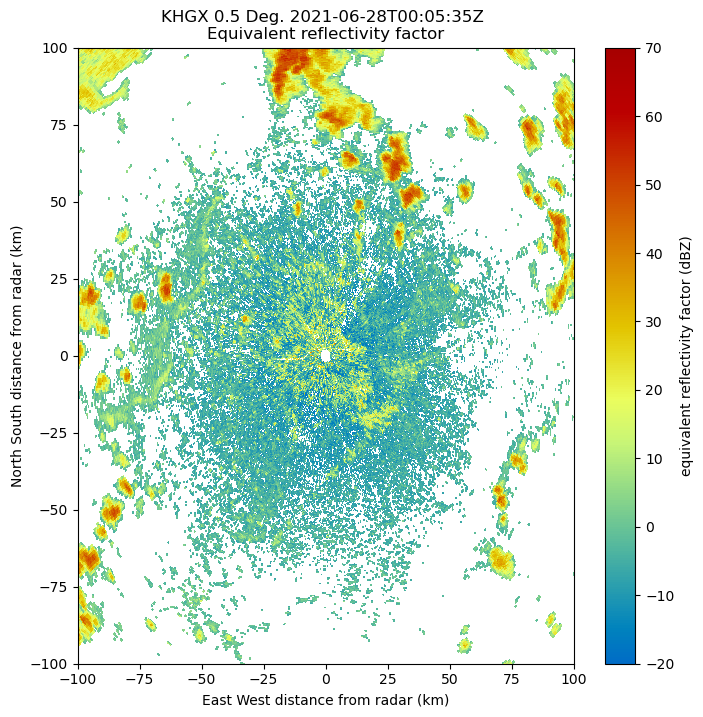

In [19]:
fig = plt.figure(figsize=(8,8))
display = pyart.graph.RadarDisplay(radars[1])
display.plot_ppi('reflectivity',sweep=0,vmin=-20,vmax=70)
display.set_limits(xlim=(-100,100),ylim=(-100,100))
#plt.savefig('Raw_Z.png')

In [73]:
def cfad_calc(data,bins,lims,norm_opt=1):
    #lims is a 4-element list or tuple (xmin, xmax, ymin, ymax). 
    #lims = 0: Use whole domain
    #bins: array of bin edge locations
    #norm_opt: 1) Normalize at each level only, 2) Normalize by max count
    
    #Initialize histogram
    hist2d = np.zeros((np.size(bins)-1,data.shape[0]))
    
    #Check if the user wants a limited domain
    limit_domain = np.size(lims) > 1
    
    if(limit_domain):
        [a,b] = np.where((X > lims[0])*(X < lims[1])*(Y > lims[2])*(Y < lims[3])) 
        
    #loop over all heights
    for lev in range(data.shape[0]):
        if(limit_domain):
            data_hist = np.ma.compressed(data[lev,a,b])
        else:
            data_hist = np.ma.compressed(data[lev,:,:])
        
        #Calculate histogram
        histogram, bin_edges = np.histogram(np.ravel(data_hist), bins)
        
        #Normalize histogram
        if(norm_opt == 1):
            if(np.sum(histogram) > 0):
                hist2d[:,lev] = histogram/np.sum(histogram)
        elif(norm_opt == 2):
            hist2d[:,lev] = histogram
        
    if(norm_opt == 2):
        #Normalize by maximum count across all heights
        hist2d /= np.max(hist2d)
                
    bin_ctrs = (bins[:-1]+bins[1:])/2
    
    return hist2d,bin_ctrs
    
def vert_stats(data,lims):
    if(np.size(lims) > 1):
        [a,b] = np.where((X > lims[0])*(X < lims[1])*(Y > lims[2])*(Y < lims[3])) 
        data_mean = np.ma.median(data[:,a,b],axis=1)
    else:
        data_mean = np.ma.mean(np.ma.mean(data,axis=2),axis=1)
        
    return data_mean
    
#dzgrid = grid.z["data"][2]-grid.z["data"][1]
#CFAD X
data = Z
binsZ = np.arange(zlims[0], zlims[1], dz)

[hist_Z, Zctr] = cfad_calc(data,binsZ,lims,norm_opt)
#hist_Z /= dz
meanZ = vert_stats(data,lims)

#CFAD ZDR
data = ZDR
binsZDR = np.arange(zdrlims[0], zdrlims[1], dzdr)
[hist_ZDR, ZDRctr] = cfad_calc(data,binsZDR,lims,norm_opt)
#hist_ZDR /= (dzdr*10)
meanZDR = vert_stats(data,lims)

#CFAD rhohv
data = rho
binsrho = np.arange(rholims[0], rholims[1], drho)
[hist_rho, rhoctr] = cfad_calc(data,binsrho,lims,norm_opt)
#hist_rho /= (drho*10000)
meanrho = vert_stats(data,lims)

#CFAD KDP
if(kdp_calc):
    data = kdp
    binskdp = np.arange(kdplims[0], kdplims[1], dkdp)
    [hist_kdp,kdpctr] = cfad_calc(data,binskdp,lims,norm_opt)
    #hist_kdp /= (dkdp*100)
    meankdp = vert_stats(data,lims)

In [27]:
grid.y['data'].shape

(401,)

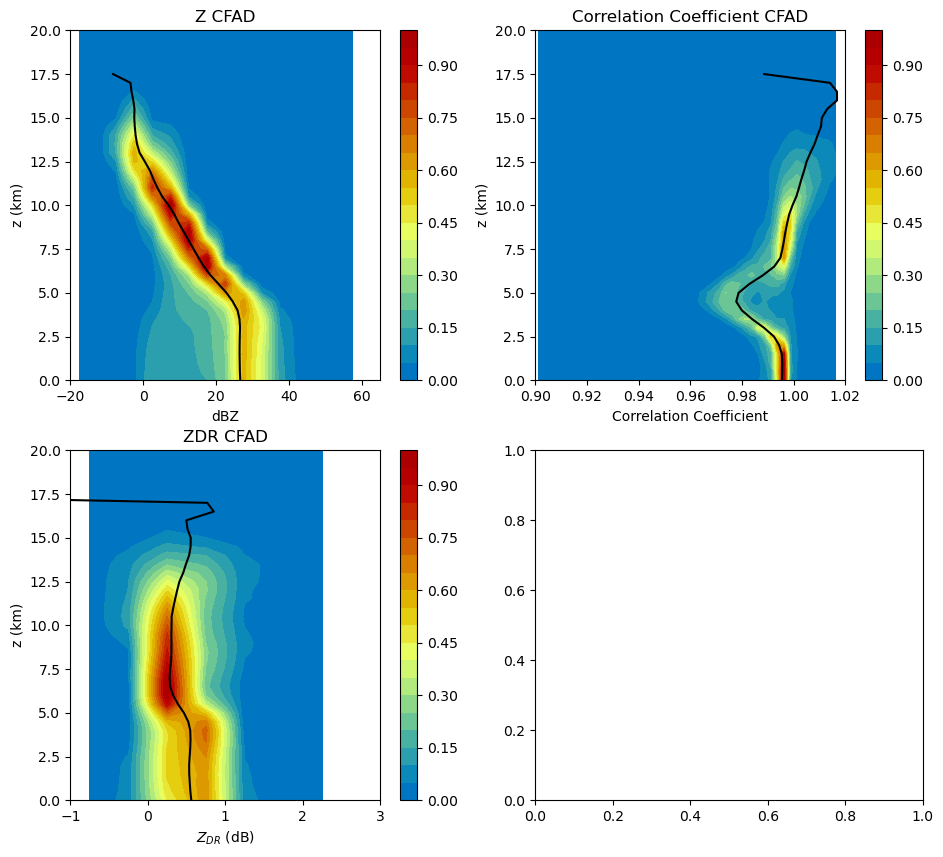

In [74]:
#Plotting levels for contours
ymax=20
fig,ax = plt.subplots(2,2,figsize=(11,10))
[z,b]=np.meshgrid(grid.z["data"],Zctr)
pcm=ax[0,0].contourf(b,z/1000,hist_Z,levels=20,cmap='pyart_HomeyerRainbow')
ax[0,0].plot(meanZ,grid.z["data"]/1000,'-k')
#ax[0,0].contour(b,z/1000,hist_Z,levels=np.arange(0.05,1,0.05),colors='k')
ax[0,0].set_xlabel('dBZ')
ax[0,0].set_ylabel('z (km)')
ax[0,0].set_title('Z CFAD')
#ax[0,0].set_title('Z CFAD (% of Data per dBZ per km)')
ax[0,0].set_xlim(zlims)
ax[0,0].set_ylim(0,ymax)
fig.colorbar(pcm, ax=ax[0,0])

[z,b]=np.meshgrid(grid.z["data"],ZDRctr)
pcm=ax[1,0].contourf(b,z/1000,hist_ZDR,levels=20,cmap='pyart_HomeyerRainbow')
#ax[1,0].contour(b,z/1000,hist_ZDR,levels=np.arange(0.05,0.5,0.05),colors='k')
ax[1,0].plot(meanZDR,grid.z["data"]/1000,'-k')
ax[1,0].set_xlabel('$Z_{DR}$ (dB)')
ax[1,0].set_ylabel('z (km)')
#ax[1,0].set_title('ZDR CFAD (% of Data per 0.1 dB per km)')
ax[1,0].set_title('ZDR CFAD')
ax[1,0].set_xlim(zdrlims)
ax[1,0].set_ylim(0,ymax)
fig.colorbar(pcm, ax=ax[1,0])

[z,b]=np.meshgrid(grid.z["data"],rhoctr)
pcm=ax[0,1].contourf(b,z/1000,hist_rho,levels=20,cmap='pyart_HomeyerRainbow')
#ax[0,1].contour(b,z/1000,hist_rho,levels=np.arange(0.05,0.5,0.05),colors='k')
ax[0,1].plot(meanrho,grid.z["data"]/1000,'-k')
ax[0,1].set_xlabel('Correlation Coefficient')
ax[0,1].set_ylabel('z (km)')
#ax[0,1].set_title('Correlation Coefficient CFAD (% of Data per 0.001 CC per km)')
ax[0,1].set_title('Correlation Coefficient CFAD')
ax[0,1].set_xlim(rholims)
ax[0,1].set_ylim(0,ymax)
fig.colorbar(pcm, ax=ax[0,1])

if(kdp_calc):
    [z,b]=np.meshgrid(grid.z["data"],kdpctr)
    pcm=ax[1,1].contourf(b,z/1000,hist_kdp,levels=20,cmap='pyart_HomeyerRainbow')
    #ax[0,1].contour(b,z/1000,hist_rho,levels=np.arange(0.05,0.5,0.05),colors='k')
    ax[1,1].plot(meankdp,grid.z["data"]/1000,'-k')
    ax[1,1].set_xlabel('Specific Differential Phase (deg/km)')
    #ax[1,1].set_title('KDP CFAD (% of Data per 0.01 deg/km per km)')
    ax[1,1].set_title('KDP CFAD')
    ax[1,1].set_ylabel('z (km)')
    ax[1,1].set_ylim(0,ymax)
    ax[1,1].set_xlim(kdplims)
    fig.colorbar(pcm, ax=ax[1,1])

fig.savefig('CFAD_norm.png')

